# Biochemical Network Tutorial

This tutorial deals with the creation and simulation of biochemical networks using bond graphs. In this tutorial, we will use the BondGraphTools package to:
* create bond graph components of biochemistry
* link components together using bonds
* draw bond graphs of biochemical networks
* set parameters for bond graph components
* simulate bond graph models of biochemical networks
* change the initial conditions and control variables for simulations
* extract efforts and flows from a bond graph to calculate reaction fluxes and affinities

We begin by importing the BondGraphTools package, as well as other packages required for this tutorial.

In [1]:
import BondGraphTools as bgt
from BondGraphTools.actions import new, add, connect
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import init_printing
init_printing()

## A simple example
In this section we work with the simple biochemical reaction $A + B \rightleftharpoons C$. The bond graph for this system is shown below, where the bonds have been numbered in blue for ease of reference as we add bonds to the model.

![](ABC.svg)

We begin by creating each of the components, and adding them to the model.

In [2]:
# Create a new model
model_ABC = new(name='ABC')

# C:A
C_A = new(component='Ce',name='A',library='BioChem')
add(model_ABC,C_A)

# C:B
C_B = new(component='Ce',name='B',library='BioChem')
add(model_ABC,C_B)

# C:C
C_C = new(component='Ce',name='C',library='BioChem')
add(model_ABC,C_C)

# Re:R1
Re = new(component='Re',name='R1',library='BioChem')
add(model_ABC,Re)

# 1 junction
flow = new(component='1',name='AB')
add(model_ABC,flow)

# List the components to check they have been added
model_ABC.components

{1: AB, C: A, C: B, C: C, R: R1}

Next we define the bonds that link the components together.  The **Re** component needs to have connections to specific ports (the forward and reverse sides) specified.

In [3]:
connect(C_A,flow) # Bond 1
connect(C_B,flow) # Bond 2
connect(flow,(Re,0)) # Bond 3
connect((Re,1),C_C) # Bond 4

# List the bonds to check they have been added
model_ABC.bonds

[Bond(tail=Port(C: B, 0), head=Port(1: AB, 1)),
 Bond(tail=Port(C: A, 0), head=Port(1: AB, 0)),
 Bond(tail=Port(R: R1, 1), head=Port(C: C, 0)),
 Bond(tail=Port(1: AB, 2), head=Port(R: R1, 0))]

We now draw the bond graph to make sure that the structure is the same as the diagram above.

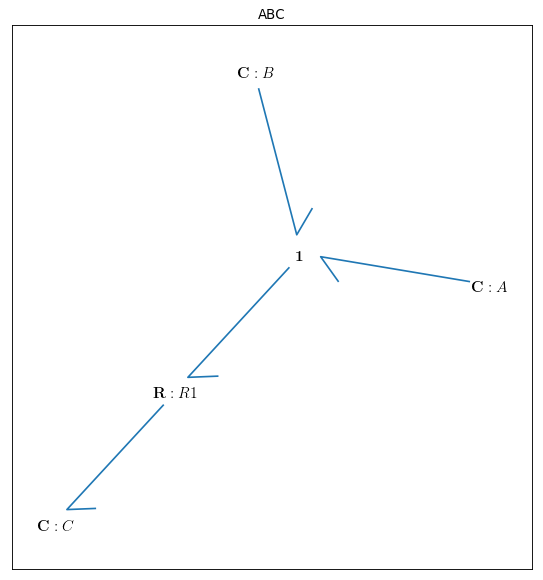

In [4]:
bgt.draw(model_ABC)

The differential equations for the model can be derived using the `constitutive_relations` method.

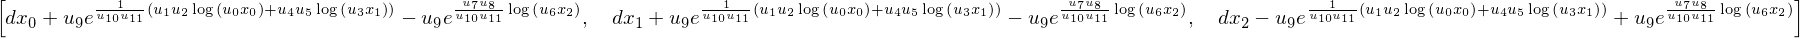

In [5]:
model_ABC.constitutive_relations

As seen above, the differential equations contain a number of unset constants - the control variables $u_n$. We will now set the parameters for each component, and derive the differential equation again.

In [6]:
# C:A
C_A.set_param('k',1)
C_A.set_param('R',1)
C_A.set_param('T',1)

# C:B
C_B.set_param('k',1)
C_B.set_param('R',1)
C_B.set_param('T',1)

# C:C
C_C.set_param('k',1)
C_C.set_param('R',1)
C_C.set_param('T',1)

# Re:R1
Re.set_param('r',1)
Re.set_param('R',1)
Re.set_param('T',1)

# Derive the differential equations
model_ABC.constitutive_relations

The equations look much more like what we expect from a reaction obeying mass balance. The definition of each state can be found by using the `state_vars` method. The states $x_0$, $x_1$ and $x_2$ correspond to A, B and C respectively.

In [7]:
model_ABC.state_vars

{'x_0': (C: A, 'q_0'), 'x_1': (C: B, 'q_0'), 'x_2': (C: C, 'q_0')}

Therefore the differential equations can be interpreted as
$$ 
\begin{align*}
\frac{dx_A}{dt} &= -x_A x_B + x_C \\
\frac{dx_B}{dt} &= -x_A x_B + x_C \\
\frac{dx_C}{dt} &= x_A x_B - x_C 
\end{align*}
$$

We will now attempt to simulate the model using the `simulate` method in BondGraphTools. We set $x_0 = 1$, $x_1 = 2$ and $x_2 = 3$ as the initial conditions, and simulate the system from $t=0$ to $t=10$. The results are plotted below.

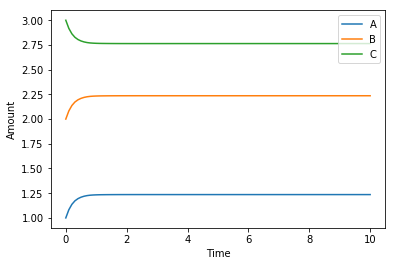

In [8]:
t,x = bgt.simulate(model_ABC, timespan=(0.,10.), x0=[1,2,3])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['A','B','C'])

We can run a different simulation for the same system using the initial conditions $x_0 = 3$, $x_1 = 1$ and $x_2 = 2$.

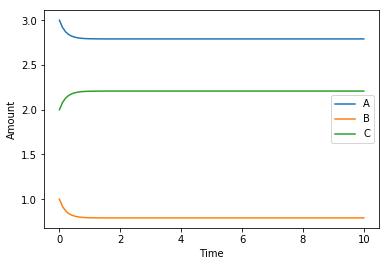

In [9]:
t,x = bgt.simulate(model_ABC, timespan=(0.,10.), x0=[3,1,2])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['A','B','C'])

## The reversible Michaelis-Menten model
Here we will create a bond graph of the two-state enzyme model used for the Michaelis-Menten equations. The chemical reactions in this system are 
$$
E + S \rightleftharpoons C \\ 
C \rightleftharpoons E + P
$$
As in the typical formulation, we assume that S and P are chemostats, i.e. their amounts are fixed at constant values. The corresponding bond graph for this system is shown below. The bonds have been labelled in blue.

![](enzyme_cycle.svg)

We begin by creating each of the components, and placing them in a list.

While we chose to initialise components without their parameters in the previous example, we use this example to demonstrate how to initialise components with their parameters. All the bond graph parameters have been set to 1, and we assume that S is fixed at an amount of 2, and P is fixed at an amount of 1.

In [10]:
model_MM = new(name='Michaelis-Menten')

R = 8.3144598
T = 310
K_S = 1
K_P = 1
x_S = 2
x_P = 1

# Chemical species
C_E = new(component='Ce',name='E',library='BioChem',value={'k':1,'R':R,'T':T})
C_C = new(component='Ce',name='C',library='BioChem',value={'k':1,'R':R,'T':T})
# Chemostats
Se_S = new(component='Se',name='S',value={'e':R*T*np.log(K_S*x_S)})
Se_P = new(component='Se',name='P',value={'e':R*T*np.log(K_P*x_P)})
# Reactions
R1 = new(component='Re',name='R1',library='BioChem',value={'r':1,'R':R,'T':T})
R2 = new(component='Re',name='R2',library='BioChem',value={'r':1,'R':R,'T':T})
# 0 junctions
ej_E = new(component='0',name='E')
ej_C = new(component='0',name='C')
# Y junctions
fj_1 = new(component='1',name='R1')
fj_2 = new(component='1',name='R2')

# Place components in a list
components = [C_E,C_C,Se_S,Se_P,R1,R2,ej_E,ej_C,fj_1,fj_2]

Each of the components have been added to a list, so they can be added to the model together.

In [11]:
add(model_MM, *components)

# Check that the components are in the model
model_MM.components

{0: C, 0: E, 1: R1, 1: R2, C: C, C: E, R: R1, R: R2, SS: P, SS: S}

We next connect the components together, as in the diagram above.

In [12]:
connect(Se_S,fj_1) # Bond 1
connect(fj_1,(R1,0)) # Bond 2
connect((R1,1),ej_C) # Bond 3
connect(ej_C,C_C) # Bond 4
connect(ej_C,(R2,0)) # Bond 5
connect((R2,1),fj_2) # Bond 6
connect(fj_2,Se_P) # Bond 7
connect(fj_2,ej_E) # Bond 8
connect(ej_E,C_E) # Bond 9
connect(ej_E,fj_1) # Bond 10

# Check that the bonds have been added
model_MM.bonds

[Bond(tail=Port(0: C, 1), head=Port(C: C, 0)),
 Bond(tail=Port(0: C, 2), head=Port(R: R2, 0)),
 Bond(tail=Port(R: R1, 1), head=Port(0: C, 0)),
 Bond(tail=Port(SS: S, 0), head=Port(1: R1, 0)),
 Bond(tail=Port(1: R1, 1), head=Port(R: R1, 0)),
 Bond(tail=Port(R: R2, 1), head=Port(1: R2, 0)),
 Bond(tail=Port(1: R2, 1), head=Port(SS: P, 0)),
 Bond(tail=Port(1: R2, 2), head=Port(0: E, 0)),
 Bond(tail=Port(0: E, 1), head=Port(C: E, 0)),
 Bond(tail=Port(0: E, 2), head=Port(1: R1, 2))]

The bond graph drawn by the software verifies these connections.

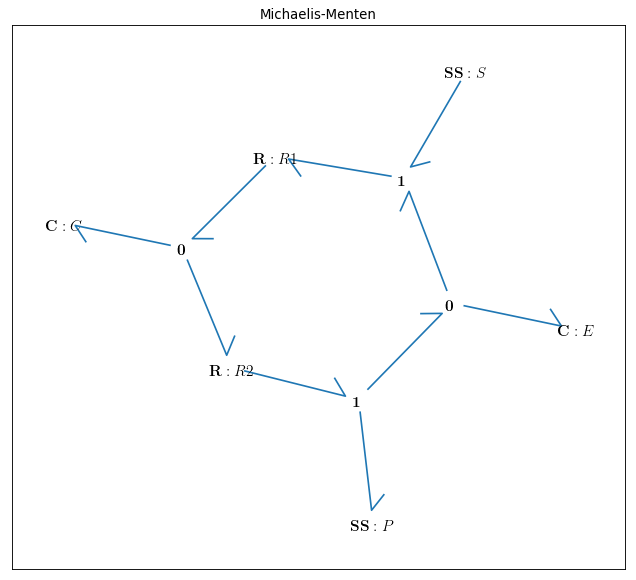

In [13]:
bgt.draw(model_MM)

For this model, the constitutive equations reduce to a linear system

In [14]:
model_MM.constitutive_relations

with the state variables defined as

In [15]:
model_MM.state_vars

{'x_0': (C: E, 'q_0'), 'x_1': (C: C, 'q_0')}

We may now simulate this model using the initial conditions $x_E = 1$ and $x_C = 2$.

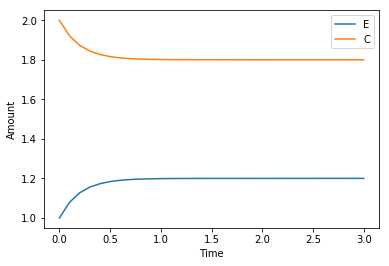

In [16]:
t,x = bgt.simulate(model_MM, timespan=(0.,3.), x0=[1,2])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['E','C'])

We may also run a simulation where the amount of substrate is gradually increased, i.e. $x_S = t$. We turn the **Se:S** component back into a controlled variable, and set the effort to be $e = RT\ln(K_S t)$. As the amount of substrate increases more of the enzyme is driven to the complex state.

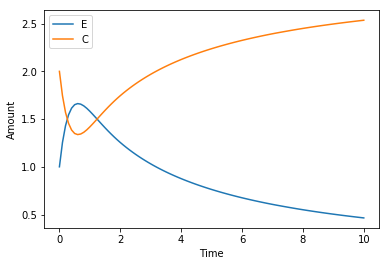

In [17]:
Se_S.set_param('e',None)
t,x = bgt.simulate(model_MM, timespan=(0.,10.), x0=[1,2], control_vars={'u_0':f'{R}*{T}*log({K_S}*t)'})
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['E','C'])

## Generating bond graph models using chemical reactions
Manually creating components and connecting them can be cumbersome. An alternative method of generating bond graph models of biochemical networks is to use the Reaction Builder module in BondGraphTools. We first import this module.

In [18]:
from BondGraphTools.reaction_builder import Reaction_Network

We define the reactions as follows. Reaction Builder interprets a string for each reaction. Reactions can also be assigned names.

In [19]:
rn_MM = Reaction_Network(name='Michaelis-Menten enzyme',temperature=310)
rn_MM.add_reaction('E + S = C', name='R1')
rn_MM.add_reaction('C = E + P', name='R2')

We will also add chemostats to indicate that the substrate and product are held at constant concentrations.

In [20]:
rn_MM.add_chemostat('S')
rn_MM.add_chemostat('P')

The `rn_MM` variable contains the necessary information about the network, including the species:

In [21]:
rn_MM.species

['E', 'S', 'C', 'P']

the reactions:

In [22]:
rn_MM._reactions

{'R1': ({'E': 1, 'S': 1}, {'C': 1}, None, None),
 'R2': ({'C': 1}, {'E': 1, 'P': 1}, None, None)}

and stoichiometry:

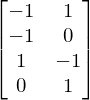

In [23]:
rn_MM.stoichiometry

We will now use this reaction network to generate a bond graph.

In [24]:
model_MM_rn = rn_MM.as_network_model()

The structure of the reaction network is the same as above.

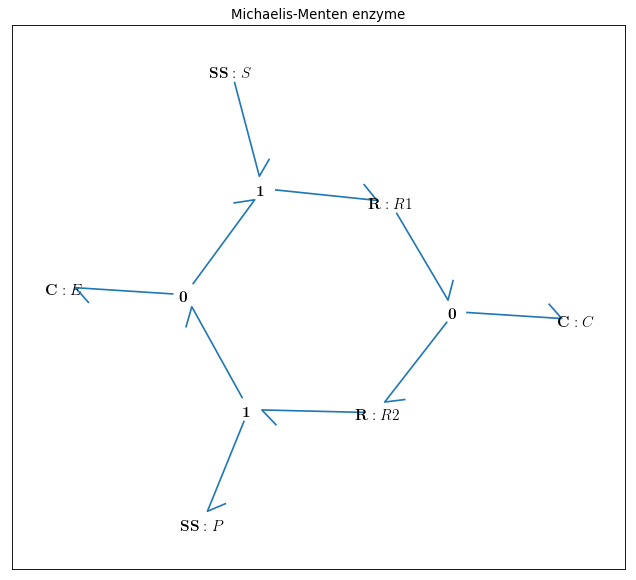

In [25]:
bgt.draw(model_MM_rn)

The constitutive equations also have the same linear form. The exponent below arises from the non-unity value of the $RT$ constant.

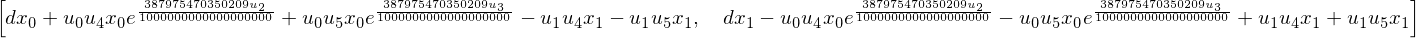

In [26]:
model_MM_rn.constitutive_relations

The state and control variables are defined below:

In [27]:
model_MM_rn.state_vars

{'x_0': (C: E, 'q_0'), 'x_1': (C: C, 'q_0')}

In [28]:
model_MM_rn.control_vars

{'u_0': (C: E, 'k'),
 'u_1': (C: C, 'k'),
 'u_2': (SS: S, 'e'),
 'u_3': (SS: P, 'e'),
 'u_4': (R: R1, 'r'),
 'u_5': (R: R2, 'r')}

As seen above, the parameters for each species and reaction are control variables that can be set. As before, we set the values to 1.

In [29]:
# Need to define a function to search for components as some of them have the same URI
def comp_search(model, metaclass, name):
    components = list(c for c in model.components if c.metaclass == metaclass and c.name == name)
    if len(components) == 1:
        return components[0]
    else:
        return components

comp_search(model_MM_rn,metaclass='C',name='E').set_param('k',1)
comp_search(model_MM_rn,metaclass='C',name='C').set_param('k',1)
comp_search(model_MM_rn,metaclass='R',name='R1').set_param('r',1)
comp_search(model_MM_rn,metaclass='R',name='R2').set_param('r',1)

We also set the values of the chemostats using the chemical potential equation

In [30]:
R = 8.3144598
T = 310
K_S = 1
K_P = 1
x_S = 2
x_P = 1
comp_search(model_MM_rn,metaclass='SS',name='S').set_param('e',R*T*np.log(K_S*x_S))
comp_search(model_MM_rn,metaclass='SS',name='P').set_param('e',R*T*np.log(K_P*x_P))

If we now show the equations of the system, we retrieve the familiar equations from the previous section.

In [31]:
model_MM_rn.constitutive_relations

These equations can be simulated in the same way as in the previous section.

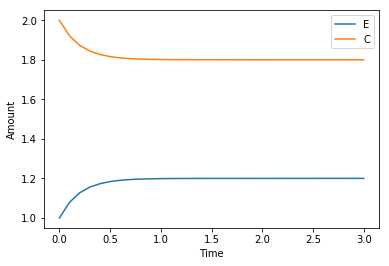

In [32]:
t,x = bgt.simulate(model_MM_rn, timespan=(0.,3.), x0=[1,2])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['E','C'])

## Calculation of energetic quantities

In some cases, we may be interested in the values associated with the bonds of each model rather than the states of the model. This may arise when we are looking at reaction rates, or the affinities of each reaction. These quantities can be extracted using the full equations of the model.

Below we define a function that outputs the full equations of the model

In [33]:
def full_equations(model):
    # Load full equations of model
    X, mapping, A, F, G = model.system_model()
    # AX + F(X) = 0
    # G(X) = 0
    AX = sp.SparseMatrix(len(X), 1, A.dot(X)) + F
    full_model_equations = {}
    for i in range(AX.rows):
        xi = X[i]
        eqn = xi - AX[i,0]
        full_model_equations[str(xi)] = eqn
    return full_model_equations

full_model_equations = full_equations(model_MM_rn)
full_model_equations

{'dx_0': -3.0*x_0**1.0 + 2*x_1**1.0,
 'dx_1': 3.0*x_0**1.0 - 2*x_1**1.0,
 'e_0': 2577.482538*log(x_0),
 'e_1': 2577.482538*log(x_1),
 'e_10': 2577.482538*log(x_0) + 1786.57475415719,
 'e_11': 2577.482538*log(x_1),
 'e_12': 2577.482538*log(x_0) + 1786.57475415719,
 'e_13': 2577.482538*log(x_0),
 'e_14': 1786.57475415719,
 'e_15': 2577.482538*log(x_1),
 'e_16': 2577.482538*log(x_0),
 'e_17': 2577.482538*log(x_0),
 'e_18': 2577.482538*log(x_0),
 'e_19': 0,
 'e_2': 2577.482538*log(x_1),
 'e_3': 2577.482538*log(x_1),
 'e_4': 2577.482538*log(x_1),
 'e_5': 2577.482538*log(x_0),
 'e_6': 2577.482538*log(x_0),
 'e_7': 2577.482538*log(x_0),
 'e_8': 1786.57475415719,
 'e_9': 0,
 'f_0': -3.0*x_0**1.0 + 2*x_1**1.0,
 'f_1': -3.0*x_0**1.0 + 2*x_1**1.0,
 'f_10': 2.0*x_0**1.0 - x_1**1.0,
 'f_11': -2.0*x_0**1.0 + x_1**1.0,
 'f_12': -2.0*x_0**1.0 + x_1**1.0,
 'f_13': 2.0*x_0**1.0 - x_1**1.0,
 'f_14': 2.0*x_0**1.0 - x_1**1.0,
 'f_15': -x_0**1.0 + x_1**1.0,
 'f_16': x_0**1.0 - x_1**1.0,
 'f_17': -x_0**1.0 +

We then search for the relevant bonds connected to the **Re** components.

In [34]:
mapping = model_MM_rn.system_model()[1]

# Define a function that returns the port for a component
def find_port(component,index):
    return list(component.ports.keys())[index]

R1 = comp_search(model_MM_rn,metaclass='R',name='R1')
bond_R1 = mapping[1][find_port(R1,0)]

R2 = comp_search(model_MM_rn,metaclass='R',name='R2')
bond_R2 = mapping[1][find_port(R2,0)]

The flows of the bonds connected to each reaction can be used to calculate their reaction rates. We first extract the corresponding components of the full equation.

In [35]:
# Create a symbolic vector of the state variables
num_states = len(model_MM_rn.state_vars)
states = [sp.Symbol('x_'+str(i)) for i in range(num_states)]

# Generate strings for the flows of the bonds connected to each reaction
f_R1 = 'f_'+str(bond_R1)
f_R2 = 'f_'+str(bond_R2)

# Extract the symbolic form of each of the flows, in terms of the states
V_R1 = full_model_equations[f_R1]
V_R2 = full_model_equations[f_R2]

In [36]:
V_R1

In [37]:
V_R2

These quantities can be converted into Python functions (taking a state vector as an import) using the `lambdify` function from `sympy`.

In [38]:
V_R1_func = sp.lambdify(([states]),V_R1)
V_R2_func = sp.lambdify(([states]),V_R2)

We use the simulation results from the previous section to calculate and plot the reaction rates. The reaction velocities converge to the same value at steady state, as expected.

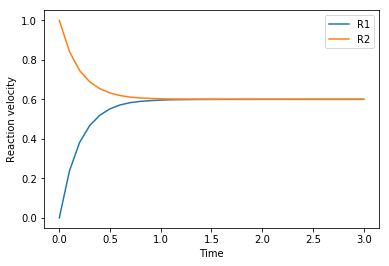

In [39]:
V = [[V_R1_func(states), V_R2_func(states)] for states in x]
plt.plot(t,V)
plt.xlabel('Time')
plt.ylabel('Reaction velocity')
plt.legend(['R1','R2'])

We can also extract the efforts of these bonds, and use them to calculate and plot the affinities of each reaction.

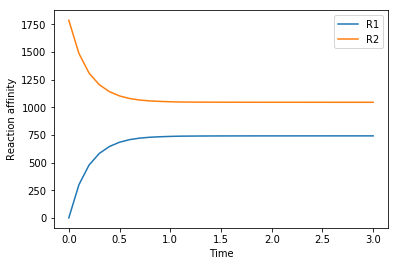

In [40]:
# Extract the bonds connected to the reactions corresponding to the forward and reverse directions
R1 = comp_search(model_MM_rn,metaclass='R',name='R1')
bond_R1f = mapping[1][find_port(R1,0)]
bond_R1r = mapping[1][find_port(R1,1)]

R2 = comp_search(model_MM_rn,metaclass='R',name='R2')
bond_R2f = mapping[1][find_port(R2,0)]
bond_R2r = mapping[1][find_port(R2,1)]

# Generate strings for the efforts of the bonds connected to each reaction
e_R1_f = 'e_'+str(bond_R1f)
e_R1_r = 'e_'+str(bond_R1r)
e_R2_f = 'e_'+str(bond_R2f)
e_R2_r = 'e_'+str(bond_R2r)

# Extract the symbolic form of each of the flows, in terms of the states
A_R1_f = full_model_equations[e_R1_f]
A_R1_r = full_model_equations[e_R1_r]
A_R2_f = full_model_equations[e_R2_f]
A_R2_r = full_model_equations[e_R2_r]

# Convert the symbolic expressions to functions
A_R1_f_func = sp.lambdify(([states]),A_R1_f)
A_R1_r_func = sp.lambdify(([states]),A_R1_r)
A_R2_f_func = sp.lambdify(([states]),A_R2_f)
A_R2_r_func = sp.lambdify(([states]),A_R2_r)

# Calculate the affinities of each reaction
A = [[A_R1_f_func(s)-A_R1_r_func(s), A_R2_f_func(s)-A_R2_r_func(s)] for s in x]
plt.plot(t,A)
plt.xlabel('Time')
plt.ylabel('Reaction affinity')
plt.legend(['R1','R2'])

Together with the reaction rates, these give the power consumption of the system.

Text(0,0.5,'Power')

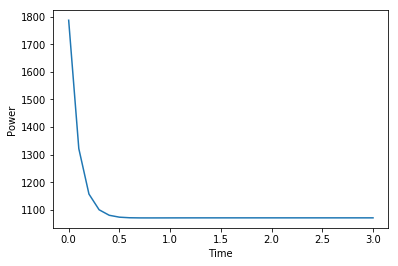

In [41]:
power = np.array(V)*np.array(A)
total_power = [sum(p) for p in power]
plt.plot(t,total_power)
plt.xlabel('Time')
plt.ylabel('Power')

It is also possible to extract the chemical potentials of each species using a similar approach. We do so in the code below, and plot how the chemical potentials change with respect to time.

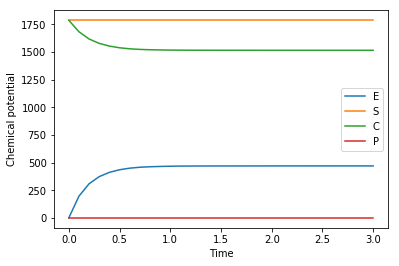

In [42]:
species_bonds = {}
species_potentials = {}
species_potential_functions = {}
chemical_potentials = {}
for species in rn_MM.species:
    comp = comp_search(model_MM_rn,metaclass='C',name=species)
    if not comp:
        comp = comp_search(model_MM_rn,metaclass='SS',name=species)
    # Find the bond index
    bond = mapping[1][find_port(comp,0)]
    # Extract the equation for the effort of the bond
    potential = full_model_equations['e_'+str(bond)]
    # Create a function for the effort
    potential_func = sp.lambdify(([states]),potential)
    # Calculate the chemical potential over the simulation
    cp = [potential_func(s) for s in x]
    
    # Store the results in a dictionary
    species_bonds[species] = bond
    species_potentials[species] = potential
    species_potential_functions[species] = potential_func
    chemical_potentials[species] = cp

# Plot the chemical potential for each species
plt.figure()
for species in species_potential_functions.keys():
    plt.plot(t,chemical_potentials[species])
plt.xlabel('Time')
plt.ylabel('Chemical potential')
plt.legend(species_potential_functions.keys())

## Creating a model of SERCA

Here we will create a bond graph model of a more complicated system - the model of SERCA described in Tran et al. (2009), which was later represented as a bond graph in Pan et al. (2018). The reaction scheme for the network is shown below.

![](Tran_SERCA.svg)

To create this model, we make lists of the reactions and chemostats.

In [43]:
reactions = [
    ("P1 + MgATP = P2", 'R1,2'),
    ("P2 + H = P2a", 'R2,2a'),
    ("P2 + 2*Cai = P4", 'R2,4'),
    ("P4 = P5 + 2*H", 'R4,5'),
    ("P5 = P6 + MgADP", 'R5,6'),
    ("P6 = P8 + 2*Casr", 'R6,8'),
    ("P8 + 2*H = P9", 'R8,9'),
    ("P9 = P10 + H", 'R9,10'),
    ("P10 = P1 + Pi", 'R10,1')
]

metabolites = ['MgATP', 'MgADP', 'Pi', 'H', 'Cai', 'Casr']

We can then use for loops to sequentially add the reactions and chemostats to the model using the Reaction Builder.

In [44]:
# Create a new reaction network
rn_SERCA = Reaction_Network(name="SERCA Network")

# Add reactions to the reaction network
for reaction, Re_name in reactions:
    rn_SERCA.add_reaction(reaction=reaction, name=Re_name)

# Add chemostats to the reaction network
for metabolite in metabolites:
    rn_SERCA.add_chemostat(metabolite)
    
# Print the species and reactions
print('Species:')
print(rn_SERCA.species)
print('\n')
print('Reactions:')
for reaction in rn_SERCA._reactions.keys():
    print(reaction, rn_SERCA._reactions[reaction])

Species:
['P1', 'MgATP', 'P2', 'H', 'P2a', 'Cai', 'P4', 'P5', 'P6', 'MgADP', 'P8', 'Casr', 'P9', 'P10', 'Pi']


Reactions:
R1,2 ({'P1': 1, 'MgATP': 1}, {'P2': 1}, None, None)
R2,2a ({'P2': 1, 'H': 1}, {'P2a': 1}, None, None)
R2,4 ({'P2': 1, 'Cai': 2}, {'P4': 1}, None, None)
R4,5 ({'P4': 1}, {'P5': 1, 'H': 2}, None, None)
R5,6 ({'P5': 1}, {'P6': 1, 'MgADP': 1}, None, None)
R6,8 ({'P6': 1}, {'P8': 1, 'Casr': 2}, None, None)
R8,9 ({'P8': 1, 'H': 2}, {'P9': 1}, None, None)
R9,10 ({'P9': 1}, {'P10': 1, 'H': 1}, None, None)
R10,1 ({'P10': 1}, {'P1': 1, 'Pi': 1}, None, None)


We then convert the reaction network into a bond graph, and draw the bond graph.

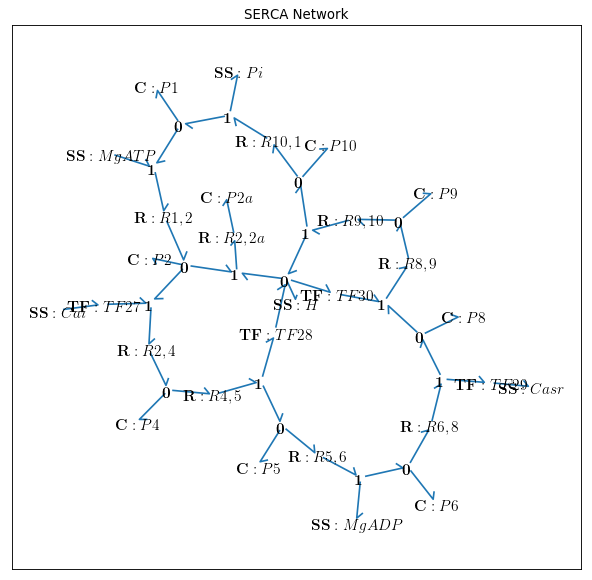

In [45]:
model_SERCA = rn_SERCA.as_network_model(normalised=True)
bgt.draw(model_SERCA)

We can also derive the differential equations for the model.

In [46]:
model_SERCA.constitutive_relations

The parameters for the model have not been set. We can define these parameters using a list.

In [47]:
reaction_rates = {
    "R1,2": 0.00053004, 
    "R2,2a": 8326784.0537,
    "R2,4": 1567.7476,
    "R4,5": 1567.7476,
    "R5,6": 3063.4006,
    "R6,8": 130852.3839,
    "R8,9": 11612934.8748,
    "R9,10": 11612934.8748,
    "R10,1": 0.049926
}

species_affinities = {"P1": 5263.6085,
                   "P2": 3803.6518,
                   "P2a": 3110.4445,
                   "P4": 16520516.1239,
                   "P5": 0.82914,
                   "P6": 993148.433,
                   "P8": 37.7379,
                   "P9": 2230.2717,
                   "P10": 410.6048,
                   "Cai": 1.9058,
                   "Casr": 31.764,
                   "MgATP": 244.3021,
                   "MgADP": 5.8126e-7,
                   "Pi": 0.014921,
                   "H": 1862.5406}

A function can be defined to automatically set these parameters.

In [48]:
def set_chemical_params(model,reaction_rates,species_affinities,Gas_Constant,Temperature):
    for reaction,rate in reaction_rates.items():
        comp = comp_search(model,metaclass='R',name=reaction)
        comp.set_param('r',rate)
        comp.set_param('R',Gas_Constant)
        comp.set_param('T',Temperature)
    for species,affinity in species_affinities.items():
        comp = comp_search(model,metaclass='C',name=species)
        if comp:
            comp.set_param('k',affinity)
            comp.set_param('R',Gas_Constant)
            comp.set_param('T',Temperature)
            
set_chemical_params(model_SERCA,reaction_rates,species_affinities,R,T)

We can also set the efforts of the chemostats automatically using a function.

In [49]:
# Define the fixed amounts for each chemostat
chemostat_amounts = {
    "Cai": 0.0057,
    "Casr": None,
    "H": 0.004028,
    "MgADP": 1.3794,
    "MgATP": 3.8,
    "Pi": 570
}

def set_chemostats(model,species_affinities,chemostat_amounts,Gas_Constant,Temperature):
    for species, affinity in species_affinities.items():
        comp = comp_search(model,metaclass='SS',name=species)
        if comp and chemostat_amounts[species] != None:
            effort = Gas_Constant*Temperature*np.log(species_affinities[species]*chemostat_amounts[species])
            comp.set_param('e',effort)

set_chemostats(model_SERCA,species_affinities,chemostat_amounts,R,T)

We check the parameters have been set by deriving the differential equation again.

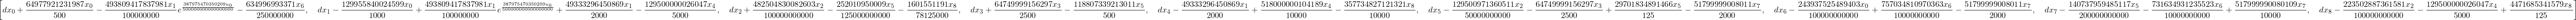

In [50]:
model_SERCA.constitutive_relations

We will next simulate this model. We first set the initial conditions of the model.

In [51]:
# Initial Conditions
initial_conditions = {
    "P1": 0.000483061870385487,
    "P2": 0.0574915174273067,
    "P2a": 0.527445119834607,
    "P4": 1.51818391164022e-09,
    "P5": 0.000521923287622898,
    "P6": 7.80721128535043e-05,
    "P8": 0.156693953834181,
    "P9": 0.149232225342376,
    "P10": 0.108044124948978
}

def simulation_ic(model,initial_conditions):
    num_states = len(model.state_vars)
    array_initial_conditions = [0]*num_states
    state_order = [[]]*num_states
    for i in range(num_states):
        comp = model.state_vars['x_'+str(i)][0]
        array_initial_conditions[i] = initial_conditions[comp.name]
        state_order[i] = comp.name
    return array_initial_conditions, state_order

array_initial_conditions, state_order = simulation_ic(model_SERCA,initial_conditions)
array_initial_conditions

We finally simulate and plot the model. The amount of SR calcium was left as a control variable, and we allow it to gradually increase over time, according to the function $[\mathrm{ Ca_{sr}^{2+}}] = 0.05+0.01t$.

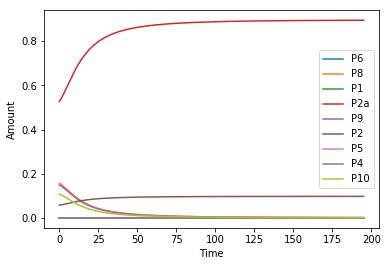

In [52]:
vol_sr = 2.28
K_Casr = species_affinities['Casr']

t,x = bgt.simulate(model_SERCA, timespan = (0.0,195.0), x0 = array_initial_conditions, dt=1, 
                   control_vars={'u_0':f'{R}*{T}*log({K_Casr}*(0.05+0.01t)*{vol_sr})'})
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(state_order)

Using the functions defined in the previous section, we can also find the flux through R1,2 to calculate the cycling rate of the pump, which we plot against SR calcium concentration.

Text(0,0.5,'Cycling rate')

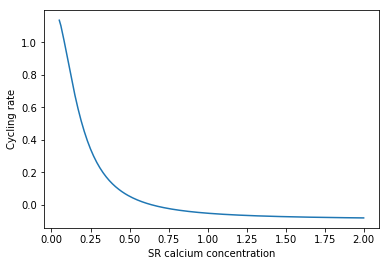

In [53]:
# Derive the full model equations
full_model_equations = full_equations(model_SERCA)

# Find the bond associated with R1
mapping = model_SERCA.system_model()[1]
R12 = comp_search(model_SERCA,metaclass='R',name='R1,2')
bond_R12 = mapping[1][find_port(R12,0)]

# Create a symbolic vector of the state variables
num_states = len(model_SERCA.state_vars)
states = [sp.Symbol('x_'+str(i)) for i in range(num_states)]

# Generate strings for the flows of the bonds connected to each reaction
f_R12 = 'f_'+str(bond_R12)

# Extract the symbolic form of each of the flows, in terms of the states
V_R12 = full_model_equations[f_R12]

# Convert the symbolic form to a function
V_R12_func = sp.lambdify(([states]),V_R12)

# Calculate the flow through the reaction using states from the simulation
cyc_rate = [V_R12_func(s) for s in x]

# Generate a vector for SR calcium concentration
Casr = [0.05+0.01*time for time in t]

# Plot the cycling rate
plt.plot(Casr,cyc_rate)
plt.xlabel('SR calcium concentration')
plt.ylabel('Cycling rate')

## References
Tran, K., Smith, N.P., Loiselle, D.S. and Crampin, E.J., 2009. A thermodynamic model of the cardiac sarcoplasmic/endoplasmic Ca2+ (SERCA) pump. *Biophysical journal*, 96(5), pp.2029-2042. https://doi.org/10.1016/j.bpj.2008.11.045

Pan, M., Gawthrop, P.J., Tran, K., Cursons, J. and Crampin, E.J., 2018. A thermodynamic framework for modelling membrane transporters. *arXiv preprint arXiv:1806.04341*. https://arxiv.org/abs/1806.04341